In [1]:
# Improvement to the omz_thickness function

In [2]:
import intake
from cmip6_omz.utils import cmip6_collection
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [3]:
# if this does not work on jupyter.rc, we can add some logic to 
col = intake.open_esm_datastore(cmip6_collection(zarr=True)) #TODO: Check with nc files

z_kwargs={"decode_times": True, "use_cftime": True, "consolidated": True}
n_kwargs={"decode_times": True, "use_cftime": True, 'chunks':{'time':3}}

variable_ids = ["thetao", "so", "o2", "agessc"] #"mlotst"
metric_variable_ids = ["thkcello", "areacello"] #"mlotst"

# models = o2_models()
# models = ['CanESM5-CanOE', 'GFDL-ESM4','CanESM5']# # shorter test run....'IPSL-CM6A-LR',
# models = [m for m in o2_models() if 'GFDL-ESM4' in m or 'Nor' in m]
models = ['GFDL-ESM4']

cat = col.search(
    source_id = models,
    grid_label=["gr"],
    experiment_id=["historical"],
    table_id=["Omon"],
    variable_id=['o2'],
)
ds_dict = cat.to_dataset_dict(
        aggregate=False,
        zarr_kwargs=z_kwargs,
        cdf_kwargs=n_kwargs,
        preprocess=combined_preprocessing,
    )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


In [4]:
from cmip6_preprocessing.postprocessing import merge_variables

In [5]:
dd = merge_variables(ds_dict)

In [6]:
dd

{'GFDL-ESM4.gr.historical.Omon.r1i1p1f1': <xarray.Dataset>
 Dimensions:        (time: 1980, lev: 35, y: 180, x: 360, bnds: 2, vertex: 4)
 Coordinates:
   * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
   * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
     lev_bounds     (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
   * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
     lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
   * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
     time_bounds    (time, bnds) object dask.array<chunksize=(3, 2), meta=np.ndarray>
     lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
     lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
     lon_verti

In [7]:
# can I wrap all these stupid masking functions into one?
from cmip6_omz.omz_tools import omz_thickness, omz_thickness_efficient

ds = dd['GFDL-ESM4.gr.historical.Omon.r1i1p1f1'].unify_chunks()
ds

<xarray.Dataset>
Dimensions:        (time: 1980, lev: 35, y: 180, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
  * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(3, 2), meta=np.ndarray>
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    o2             (time, lev, y, x) float32 dask.array<chunksize=(3, 35, 180, 360), meta=np.ndarray>
Attributes: (12/48)
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    [0.0]
    branch_time_in_parent:   [36500.0]
    comment:                 <null ref>
    ...                      ...
    tracking_id:             hdl:21.14100/4af5fdf5-2456-4bd9-992e-8009544688a6
    variable_id:             o2
    variant_info:            N/A
    variant_label:           r1i1p1f1
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omo...

In [8]:
from cmip6_omz.upstream_stash import construct_static_dz
ds = construct_static_dz(ds).rename({'thkcello':'dz_t'})

In [78]:
from xhistogram.xarray import histogram
def test_histogram(ds):
    return histogram(ds.o2, bins=np.array([-100, 5, 10, 20, 40, 60, 80, 100, 120, 140]), dim=[], weights=ds.dz_t)

In [68]:
ds_test = ds.isel(time=slice(0,3))

In [104]:
test_old = omz_thickness(ds_test)
test_old

<xarray.DataArray (o2_bin: 9, time: 3, lev: 35, y: 180, x: 360)>
dask.array<concatenate, shape=(9, 3, 35, 180, 360), dtype=float32, chunksize=(1, 3, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 1850-01-16 12:00:00 ... 1850-03-16 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    dz_t     (lev) float64 5.0 10.0 10.0 15.0 22.5 ... 500.0 500.0 500.0 500.0
  * o2_bin   (o2_bin) int64 5 10 20 40 60 80 100 120 140

In [119]:
test_new = omz_thickness_efficient(ds_test, bin_chunks=2)
test_new

<xarray.DataArray 'dz_t' (lev: 35, time: 3, y: 180, x: 360, o2_bin: 9)>
dask.array<where, shape=(35, 3, 180, 360, 9), dtype=float64, chunksize=(35, 3, 180, 360, 2), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    dz_t     (lev) float64 5.0 10.0 10.0 15.0 22.5 ... 500.0 500.0 500.0 500.0
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) object 1850-01-16 12:00:00 ... 1850-03-16 12:00:00
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * o2_bin   (o2_bin) int64 5 10 20 40 60 80 100 120 140

In [120]:
test_hist = test_histogram(ds_test)
test_hist

<xarray.DataArray 'histogram_o2' (time: 3, lev: 35, y: 180, x: 360, o2_bin: 9)>
dask.array<sum-aggregate, shape=(3, 35, 180, 360, 9), dtype=float64, chunksize=(3, 35, 180, 360, 9), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1850-03-16 12:00:00
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * o2_bin   (o2_bin) float64 -47.5 7.5 15.0 30.0 50.0 70.0 90.0 110.0 130.0

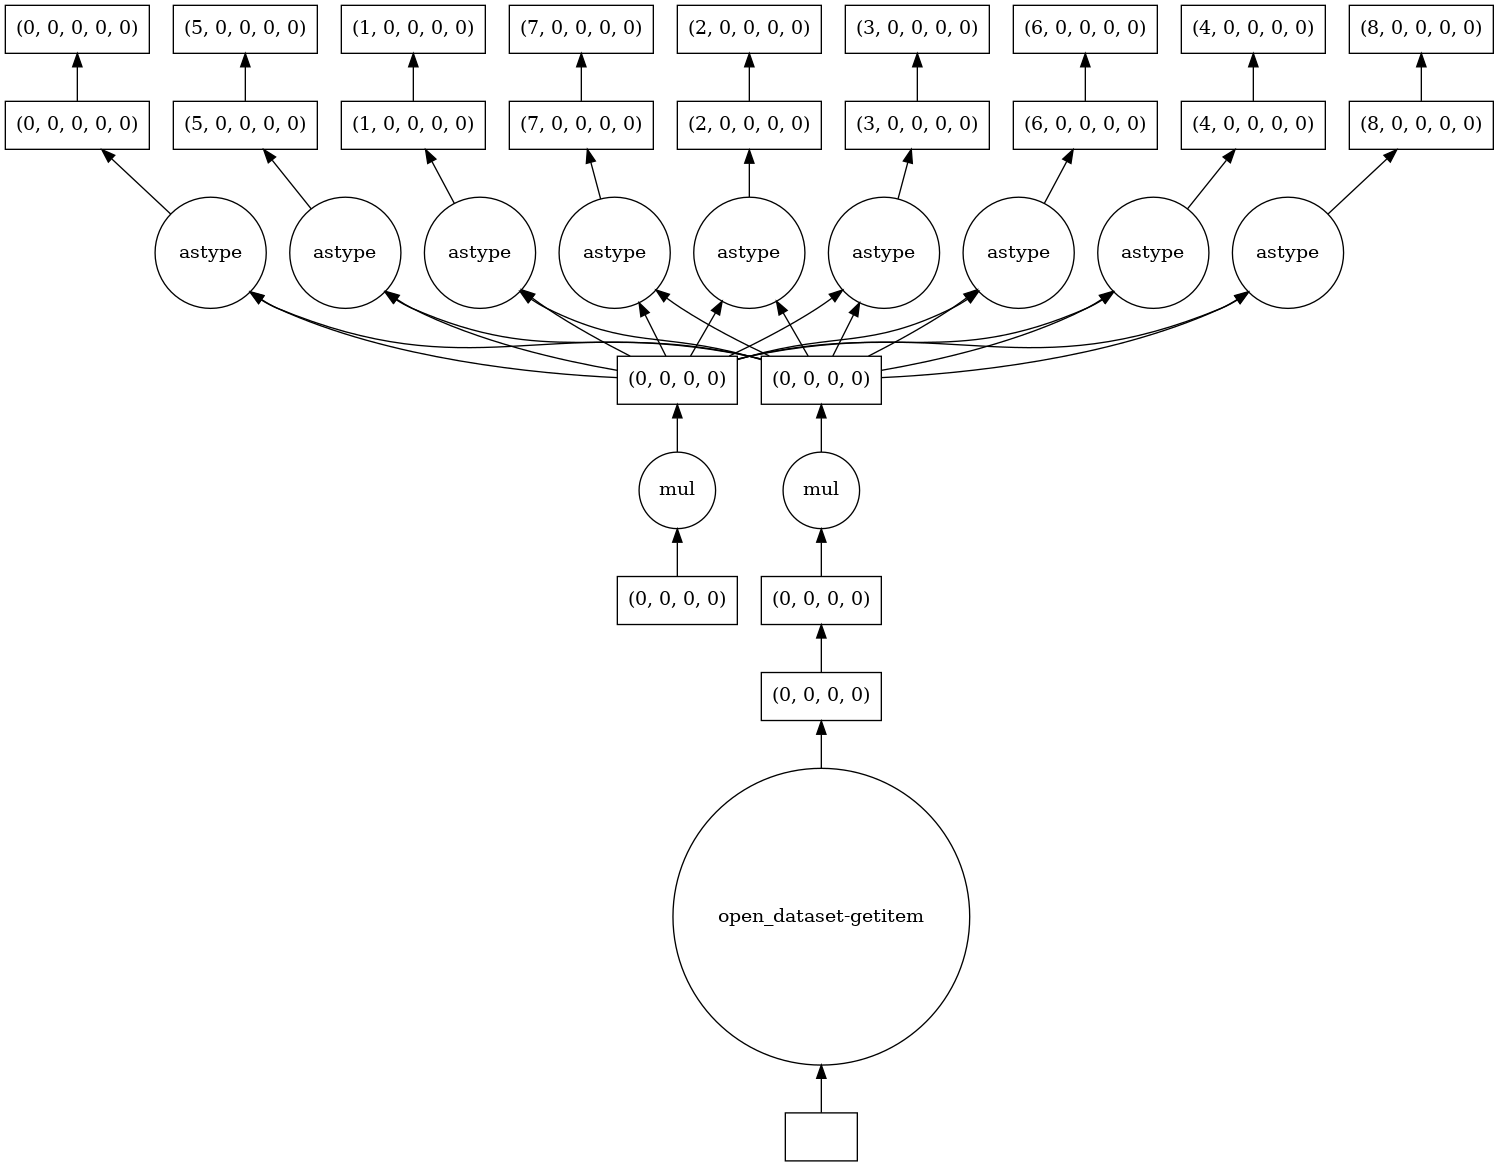

In [121]:
test_old.data.visualize(optimize_graph=True)

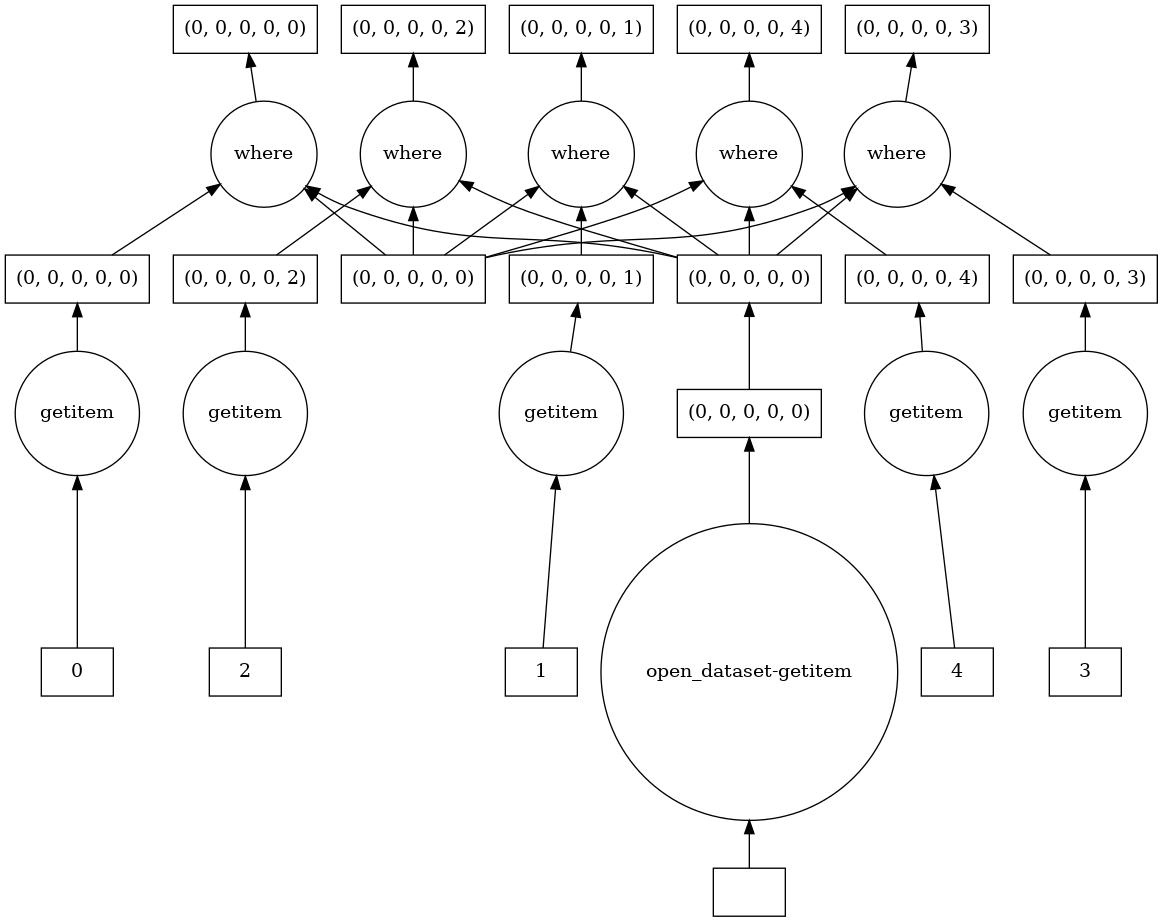

In [122]:
test_new.data.visualize(optimize_graph=True)

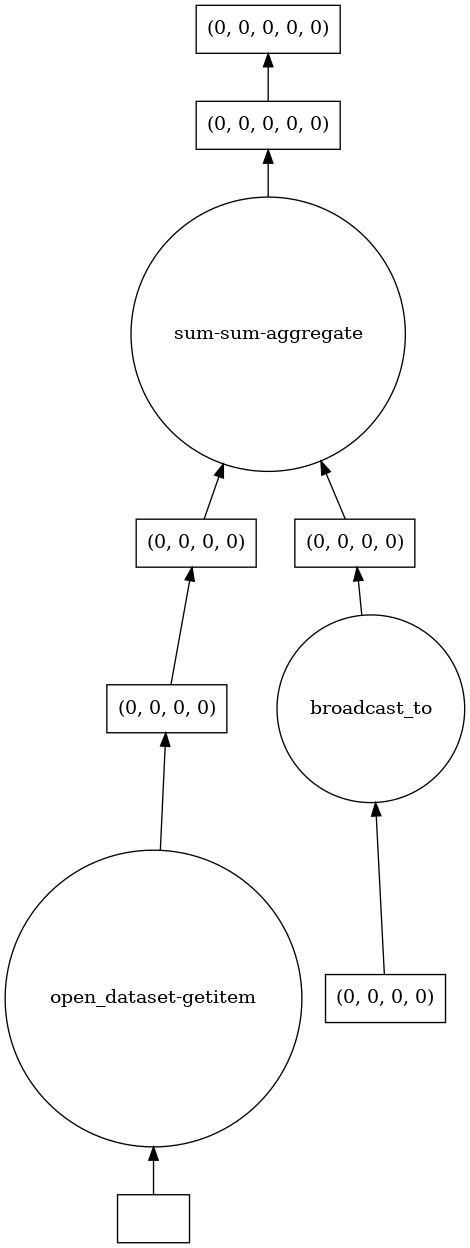

In [123]:
test_hist.data.visualize(optimize_graph=True)

In [88]:
# !mamba install python-graphviz -y

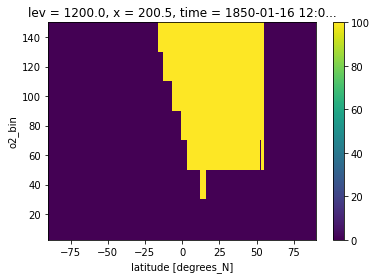

In [71]:
test_old.isel(time=0, x=200, lev=20).load().plot()

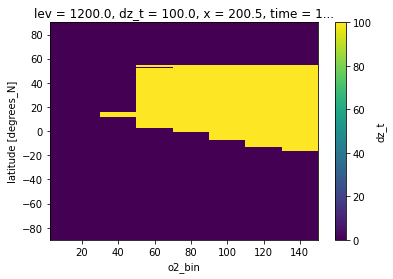

In [72]:
test_new.isel(time=0, x=200, lev=20).load().plot()

In [125]:
test_hist.isel(time=0, x=200, lev=20).load().plot()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [73]:
xr.testing.assert_allclose(test_old.isel(time=0).transpose('o2_bin', 'lev', 'y', 'x'), test_new.isel(time=0).transpose('o2_bin', 'lev', 'y', 'x'))

In [124]:
xr.testing.assert_allclose(test_old.isel(time=0).transpose('o2_bin', 'lev', 'y', 'x'), test_hist.isel(time=0).transpose('o2_bin', 'lev', 'y', 'x'))

TypeError: 'numpy.float64' object cannot be interpreted as an integer